In [8]:
import json
import js 
from js import fetch
import pandas as pd
from datetime import datetime
from pyodide.ffi import to_js
from js import Object

# Special packages already ready
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# Custom importations from special package
# Below stuff to be shortened
import piplite
await piplite.install("mplfinance")
import mplfinance as mpf

%pip install jinja2

---

# Bullish Signal

#### Why?
- Did you find it difficult to understand candlestick charts? 
- Did you fail to predict a pattern correctly?
- Why didn't you check the ratios before "betting your money"?

#### Usage
Click the >>(Run all steps) icon above to run this Script

#### What?
The script provides you with an ability to determine the purely bearish candlestick pattern. This script has been explained in [this](https://zerodha.com/varsity/chapter/single-candlestick-patterns-part-1/) blog by Karthik Rangappa of Zerodha's educational head.
*Note: Values are limits are taken from the blog, feel free to change to your likings.*

---

## Grabbing data

***The data being provisioned is only for educational purposes***


*Note: You can use the free service limits usage to only 100 symbols per minute. Tampering with this system will result in discontinuation of the service*

## Adding symbols

Please feel free to add any **NSE SYMBOL** to the below list

In [2]:
symbols = "ADANIENT,ADANIPORTS,APOLLOHOSP,ASIANPAINT,AXISBANK,\
BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BHARTIARTL,BPCL,BRITANNIA,\
CIPLA,COALINDIA,\
DIVISLAB,DRREDDY,\
EICHERMOT,\
GRASIM,\
HCLTECH,HDFC,HDFCBANK,HDFCLIFE,HEROMOTOCO,HINDALCO,HINDUNILVR,\
ICICIBANK,INDUSINDBK,INFY,ITC,\
JSWSTEEL,\
KOTAKBANK,\
LT,\
M&M,MARUTI,\
NESTLEIND,NTPC,\
ONGC,\
POWERGRID,\
RELIANCE,\
SBIN,SBILIFE,SUNPHARMA,\
TATAMOTORS,TATASTEEL,TCS,TATACONSUM,TECHM,TITAN,\
ULTRACEMCO,UPL,\
WIPRO"

In [3]:
corsprox = "https://corsproxy.io/?"
apiBaseURL = "https://query1.finance.yahoo.com/v8/finance/chart/"
rangeOfData = "1mo"
intervalOfData = "1d"
apiSymbol = []
for symbol in symbols.split(","):
    apiSymbol.append(symbol+".NS")
stockPandasTot = {}
for apiSymbolIndivi in apiSymbol:
    print(apiSymbolIndivi)
    apiCompleteURL = corsprox+apiBaseURL+apiSymbolIndivi+\
        "?range="+rangeOfData+"&interval="+intervalOfData
    resp = await js.fetch(apiCompleteURL, to_js({
                    "mode": "cors",
                    "credentials":"omit",
                    "headers": {'Accept': 'application/json',
                                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
                                'Origin':'https://yahoo.com',
                                }
                    }, dict_converter=Object.fromEntries))
    text = await resp.text()
    pan = pd.read_json(text)
    a_hist = pan['chart'][1][0]
    stockPandas = pd.DataFrame(a_hist['indicators']['quote'][0],
                               index=pd.to_datetime(a_hist['timestamp'],unit='s'))
    stockPandas = stockPandas.reindex(columns=['open','high','low','close','volume'])
    stockPandas = stockPandas[::-1]
    stockPandasTot[apiSymbolIndivi] = stockPandas
# Uncomment below line to show data
# stockPandasTot

ADANIENT.NS
ADANIPORTS.NS
APOLLOHOSP.NS
ASIANPAINT.NS
AXISBANK.NS
BAJAJ-AUTO.NS
BAJFINANCE.NS
BAJAJFINSV.NS
BHARTIARTL.NS
BPCL.NS
BRITANNIA.NS
CIPLA.NS
COALINDIA.NS
DIVISLAB.NS
DRREDDY.NS
EICHERMOT.NS
GRASIM.NS
HCLTECH.NS
HDFC.NS
HDFCBANK.NS
HDFCLIFE.NS
HEROMOTOCO.NS
HINDALCO.NS
HINDUNILVR.NS
ICICIBANK.NS
INDUSINDBK.NS
INFY.NS
ITC.NS
JSWSTEEL.NS
KOTAKBANK.NS
LT.NS
M&M.NS
MARUTI.NS
NESTLEIND.NS
NTPC.NS
ONGC.NS
POWERGRID.NS
RELIANCE.NS
SBIN.NS
SBILIFE.NS
SUNPHARMA.NS
TATAMOTORS.NS
TATASTEEL.NS
TCS.NS
TATACONSUM.NS
TECHM.NS
TITAN.NS
ULTRACEMCO.NS
UPL.NS
WIPRO.NS


### Notes
You currently have a limitation of receiving data of at most 3 month and requests to 200 requests per hour

---

## Bullish Marubozu

[![A Bullish Marubozu](https://howtotradeblog.com/wp-content/uploads/2021/01/bullish-marubozu-pattern.jpg)](https://howtotradeblog.com/wp-content/uploads/2021/01/bullish-marubozu-pattern.jpg)

The bullish Marubozu is described when 
$$ Open=Low \\
\& \\ High=Close$$

### Bullish signal

Bullish signal is when the 0 day's signal envelopes the previous day's signal 

Here are the requirements as from above blog entry
- No previous trend required
- Close > Open
- Shadows should be within $0.3\%$
- Candle should be from $1\%$ to $10\%$ range
- dates weightages are till day 3 as follows
  - With weights as follows
  - $ day 0 : 15 $
  - $ day 1 : 10 $
  - $ day 2 : 5 $
  - $ day 3 : 2 $

In [4]:
## Variables
# Number of days checked [Can we push this dates checked to different cell?]
datesChecked = 16
# weights of each individual day (Shape in reshape function should be matched. )
weights = np.array([15, 10, 5, 2])
# Adding additional weights, will be helfull only while checking.
weights = np.append(weights, np.ones((datesChecked-4,1)))
signalBullDict = {}

In [5]:
# I personally prefer numpy for math calculations.
for symbol in stockPandasTot:
    print(symbol)
    selectData = stockPandasTot[symbol].to_numpy()
    signalBull = np.zeros(datesChecked)
    for i in range(datesChecked) :
        row = selectData[i,:]
        #The rows have open, high, low, close, volume data
        # only check for today
        if i == 0:
        # If: Close < Open signal -1
            if row[3] < row[0]:
                signalBull[i] = -1
            # If: Close > Open
        if row[3] > row[0]: 
            upperShadow = row[1] - row[3]
            lowerShadow = row[0] - row[2]
            # if: Shadows within appropriate limits.
            if (upperShadow/row[3] < 0.005) and (lowerShadow/row[3] < 0.005):
                candle = row[3] - row[0]
                # if: Candles are within appropriate limits (not too small or large)
                if (candle/row[3] > 0.01) and (candle/row[3] < 0.1 ):
                    signalBull[i] = 1
    signalBull = weights*signalBull
    signalBullDict[symbol] = signalBull
# Uncomment the below line for debugging
# signalBullDict

ADANIENT.NS
ADANIPORTS.NS
APOLLOHOSP.NS
ASIANPAINT.NS
AXISBANK.NS
BAJAJ-AUTO.NS
BAJFINANCE.NS
BAJAJFINSV.NS
BHARTIARTL.NS
BPCL.NS
BRITANNIA.NS
CIPLA.NS
COALINDIA.NS
DIVISLAB.NS
DRREDDY.NS
EICHERMOT.NS
GRASIM.NS
HCLTECH.NS
HDFC.NS
HDFCBANK.NS
HDFCLIFE.NS
HEROMOTOCO.NS
HINDALCO.NS
HINDUNILVR.NS
ICICIBANK.NS
INDUSINDBK.NS
INFY.NS
ITC.NS
JSWSTEEL.NS
KOTAKBANK.NS
LT.NS
M&M.NS
MARUTI.NS
NESTLEIND.NS
NTPC.NS
ONGC.NS
POWERGRID.NS
RELIANCE.NS
SBIN.NS
SBILIFE.NS
SUNPHARMA.NS
TATAMOTORS.NS
TATASTEEL.NS
TCS.NS
TATACONSUM.NS
TECHM.NS
TITAN.NS
ULTRACEMCO.NS
UPL.NS
WIPRO.NS


---
### Displaying results 
In this section we shall see the various manners that we can display the results

The below dataframe shows how the bullish signal has appeared on the chart for the past 50 days

In [9]:
signalBullPand = pd.DataFrame(signalBullDict).T

def color_mapper(row):
    # compute the sum of the row
    sum = row.sum()
    # if the sum is negative, return red
    if sum < 0:
        return ['color: white; background-color: rgb(120, 50, 20)'] * len(row)
    # if the sum is positive, map it to a shade of green based on its magnitude
    else:
        magnitude = sum*10
        r = 15
        g = magnitude
        b = 15
        return [f'color: white; background-color: rgb({r},{g},{b})'] * len(row)

def make_pretty(styler):
    styler.apply(color_mapper,axis=1)
    styler.format(precision=1)
    return styler

signalBullPand.style.pipe(make_pretty)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
ADANIENT.NS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADANIPORTS.NS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
APOLLOHOSP.NS,-15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ASIANPAINT.NS,-15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AXISBANK.NS,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BAJAJ-AUTO.NS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BAJFINANCE.NS,-15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BAJAJFINSV.NS,-15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BHARTIARTL.NS,15.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
BPCL.NS,-15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Plotting
Innumerous plotting is possible with several methods I prefer the mplfinance package, but others will be easily implemented. Here you can see the volumes, 
moving averages and candlebar.

ADANIENT.NS


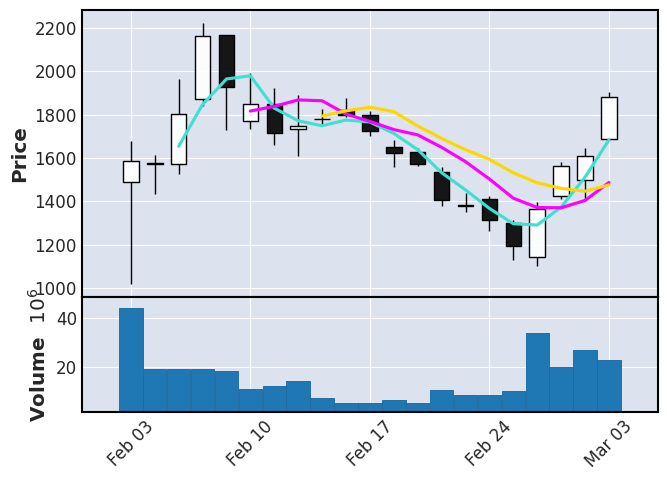

ADANIPORTS.NS


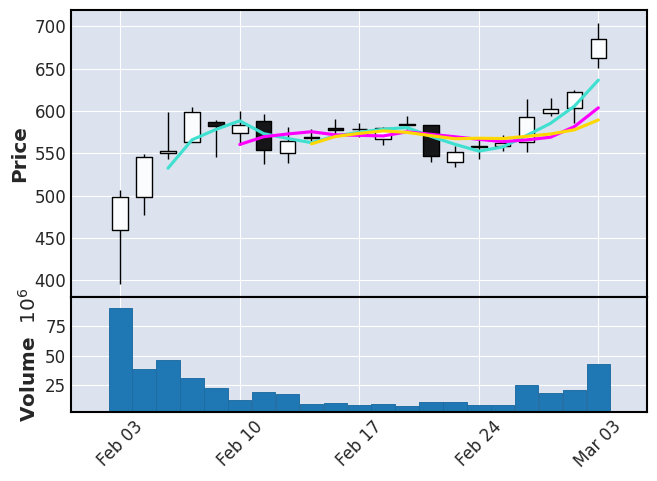

APOLLOHOSP.NS


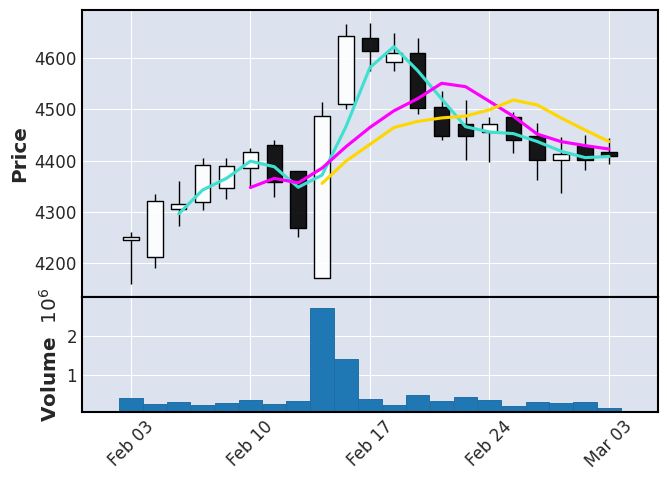

ASIANPAINT.NS


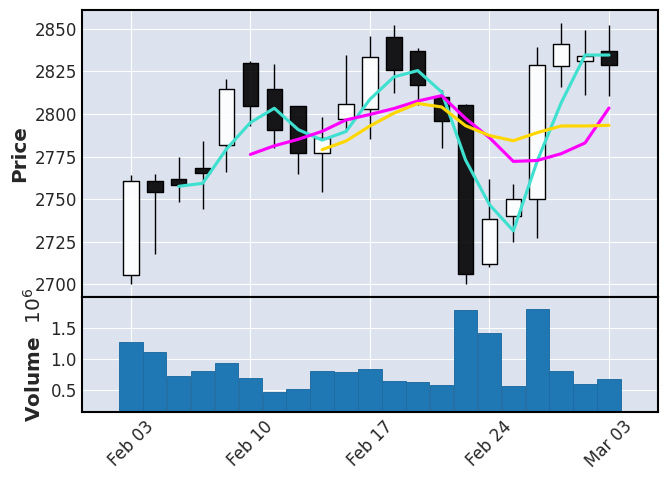

AXISBANK.NS


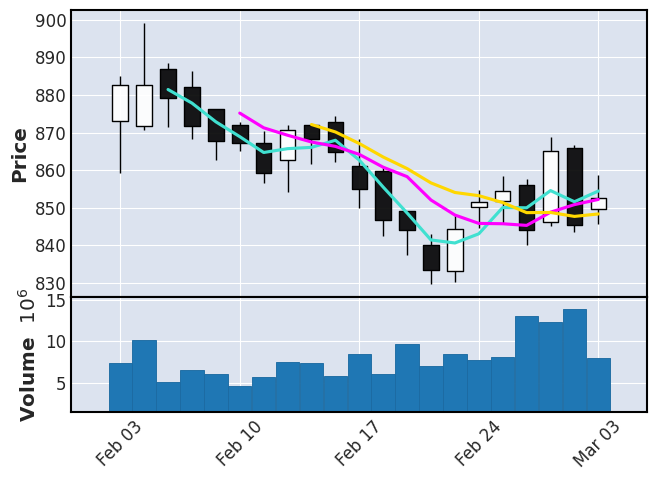

BAJAJ-AUTO.NS


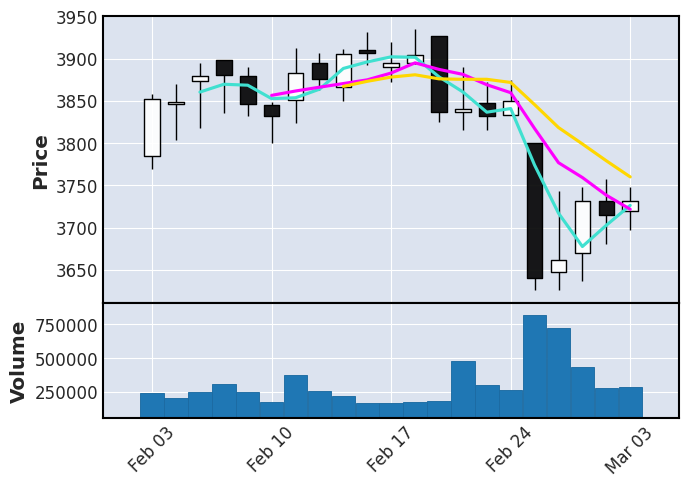

BAJFINANCE.NS


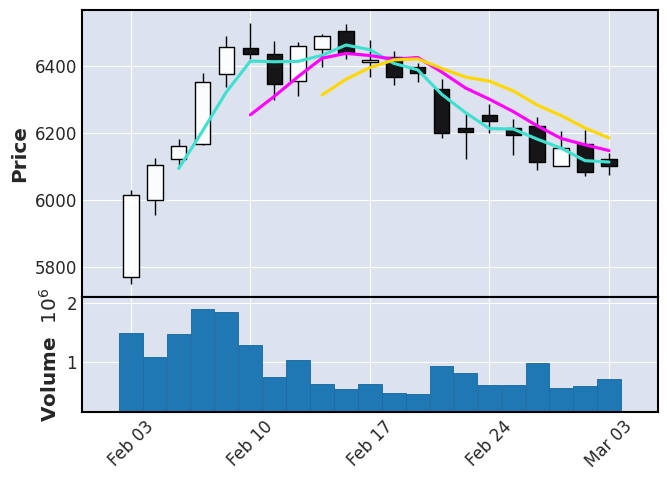

BAJAJFINSV.NS


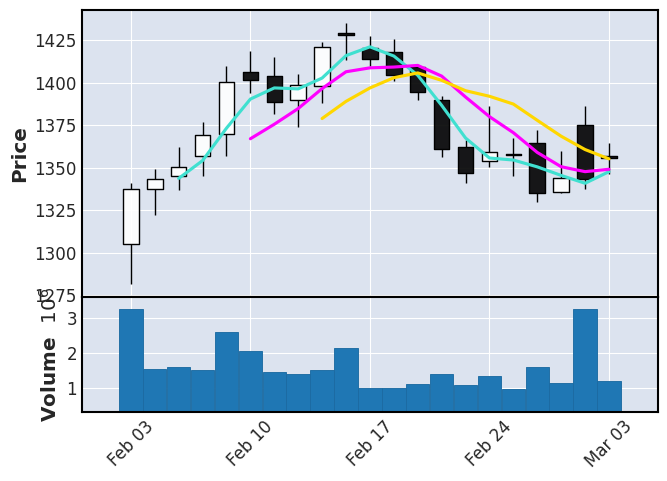

BHARTIARTL.NS


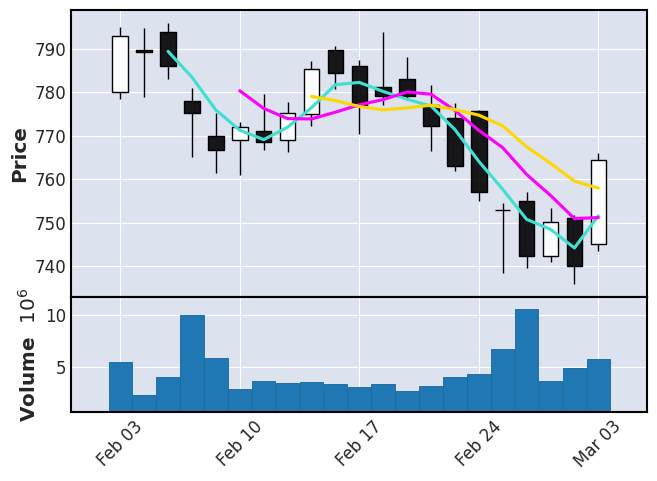

BPCL.NS


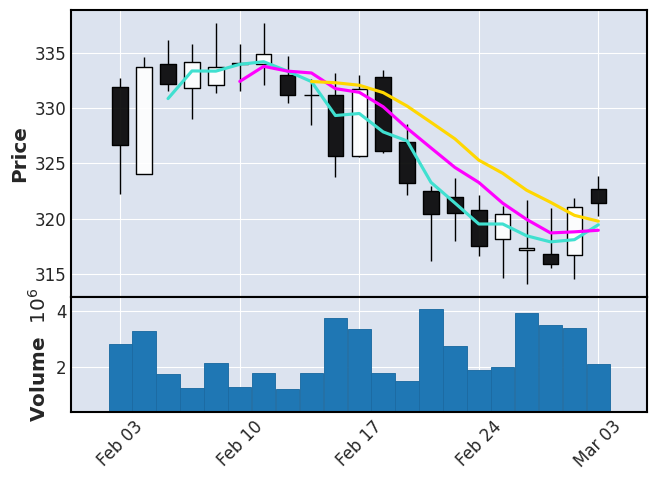

BRITANNIA.NS


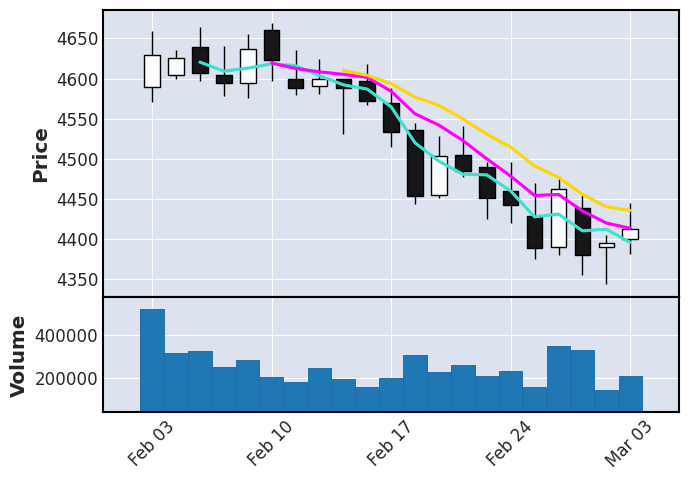

CIPLA.NS


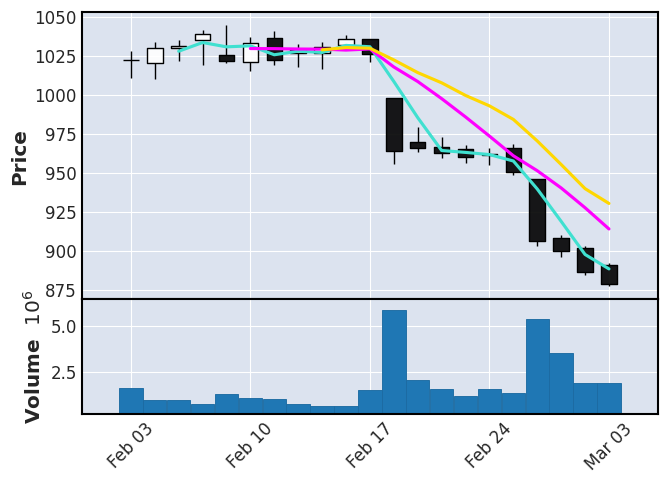

COALINDIA.NS


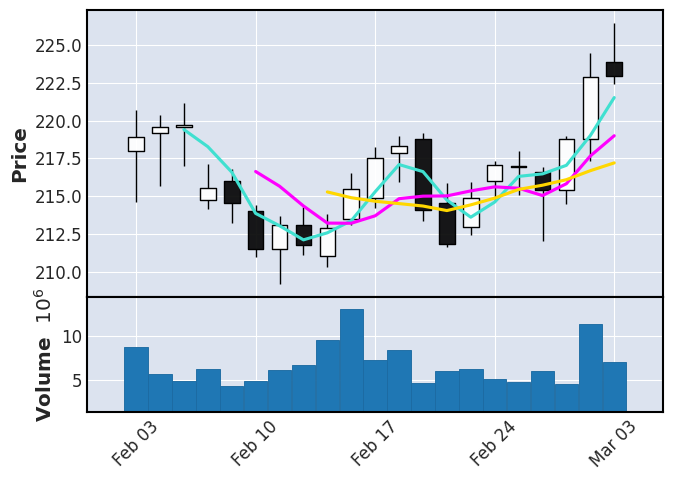

DIVISLAB.NS


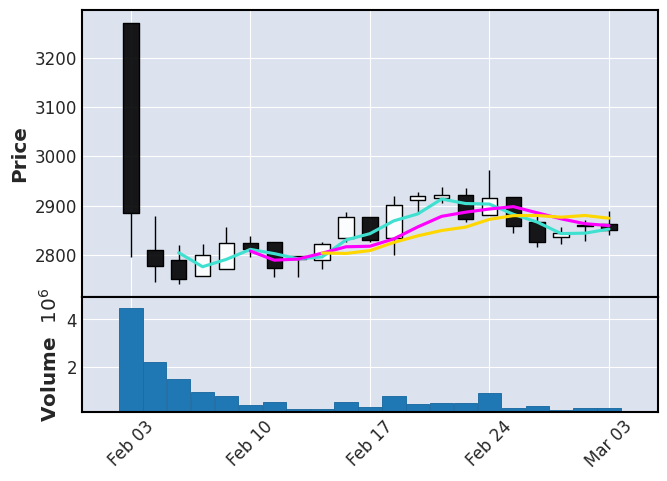

DRREDDY.NS


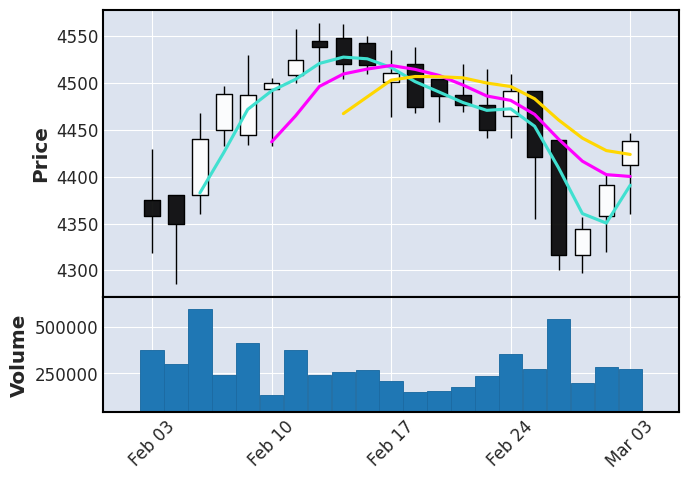

EICHERMOT.NS


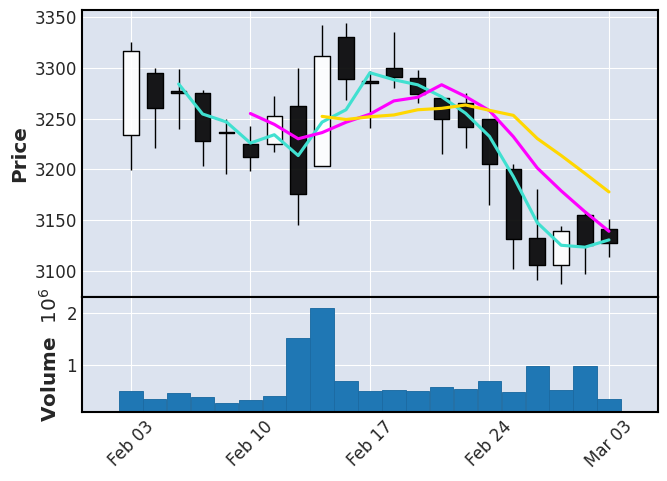

GRASIM.NS


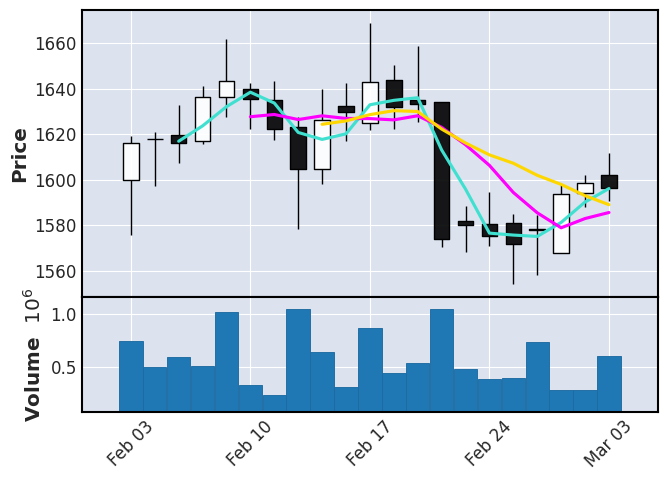

HCLTECH.NS


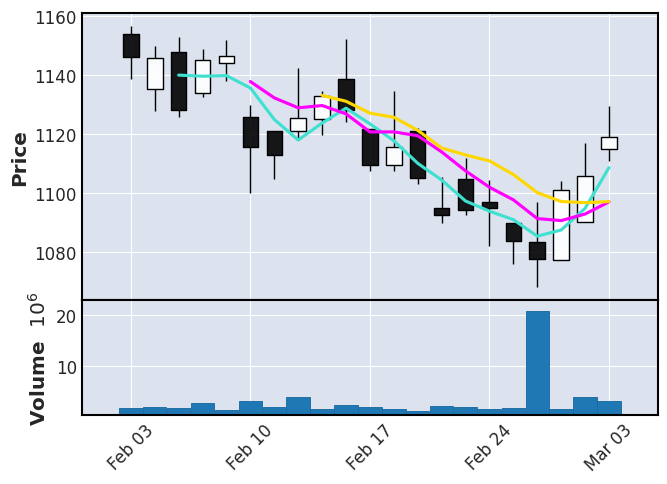

HDFC.NS


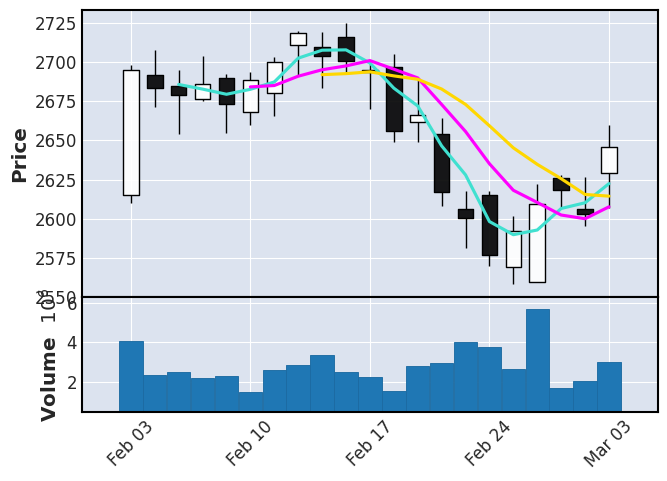

HDFCBANK.NS


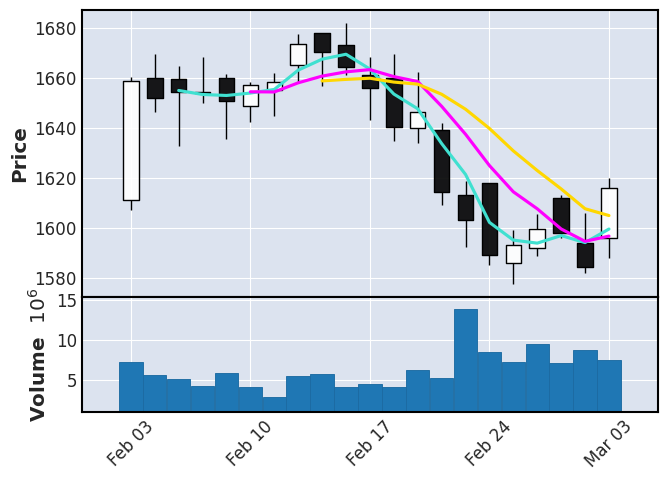

HDFCLIFE.NS


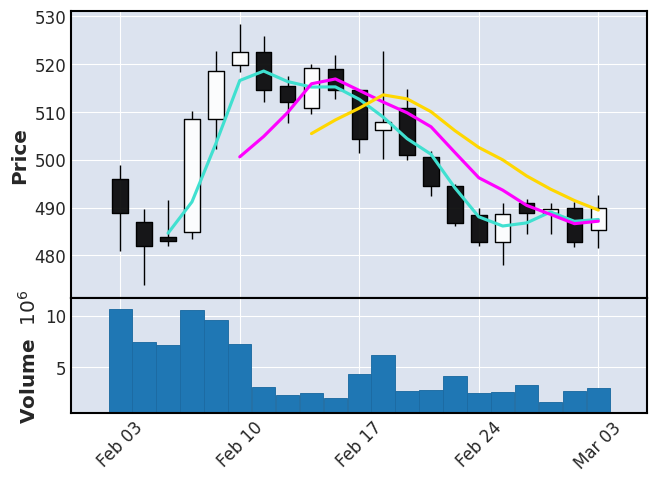

HEROMOTOCO.NS


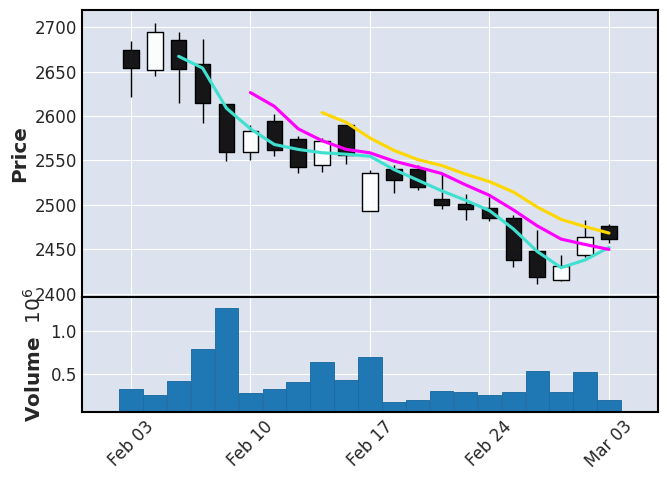

HINDALCO.NS


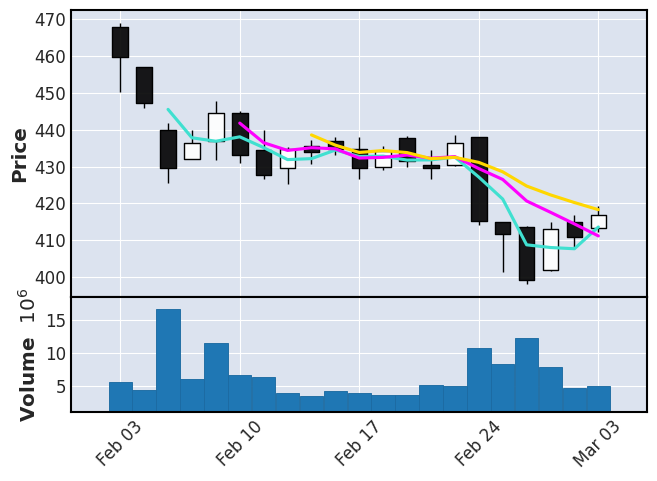

HINDUNILVR.NS


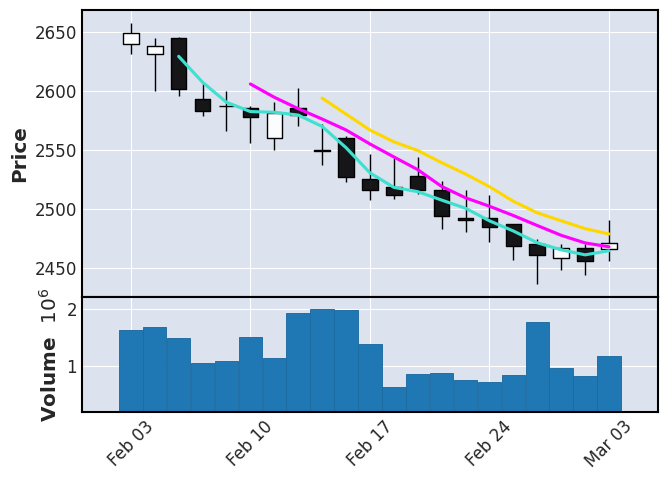

ICICIBANK.NS


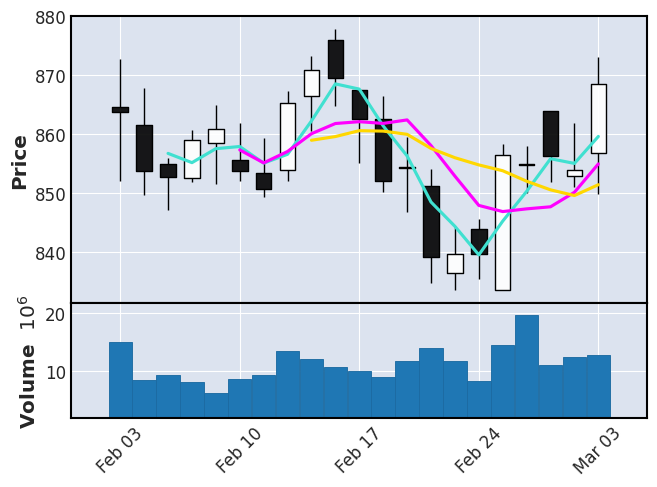

INDUSINDBK.NS


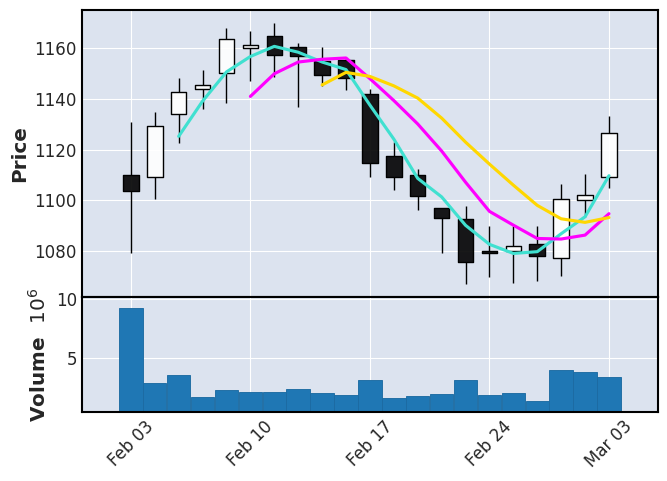

INFY.NS


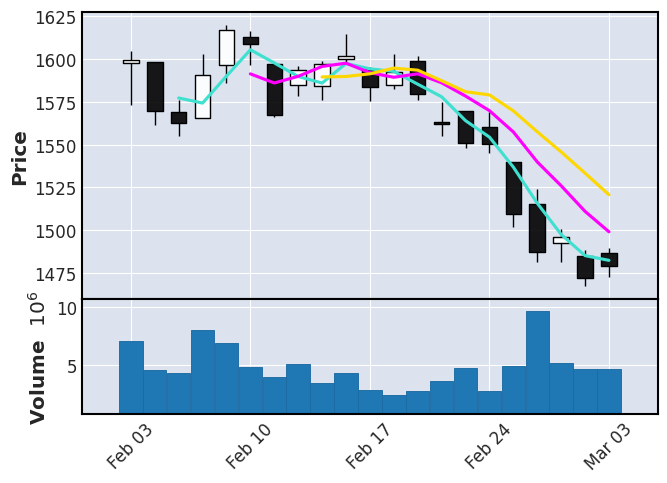

ITC.NS


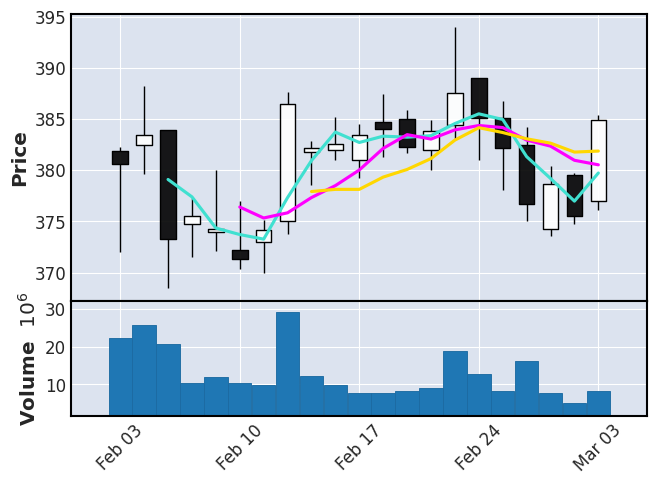

JSWSTEEL.NS


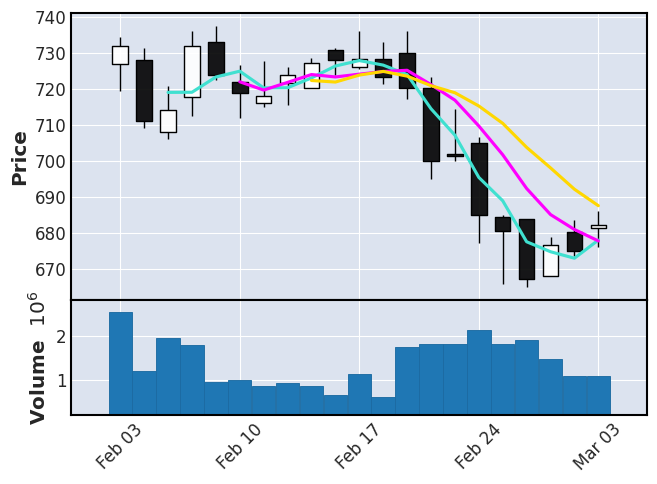

KOTAKBANK.NS


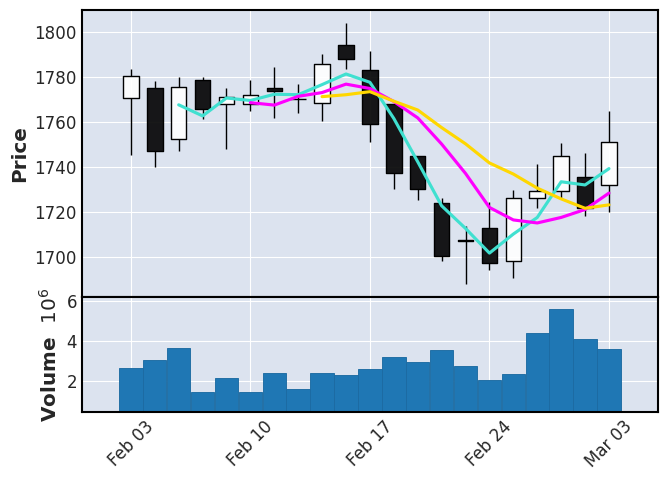

LT.NS


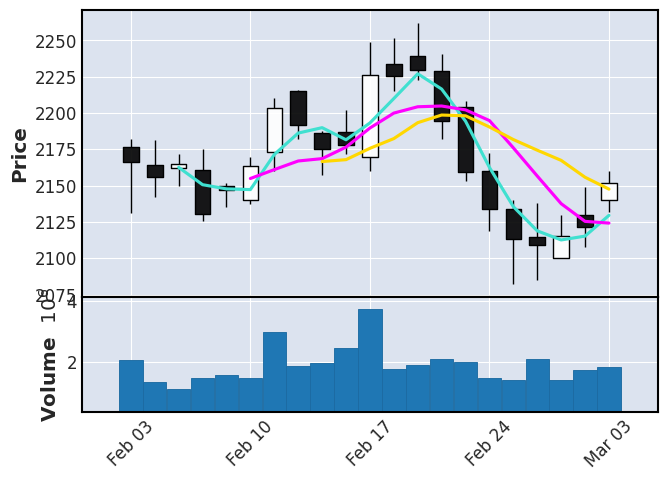

M&M.NS


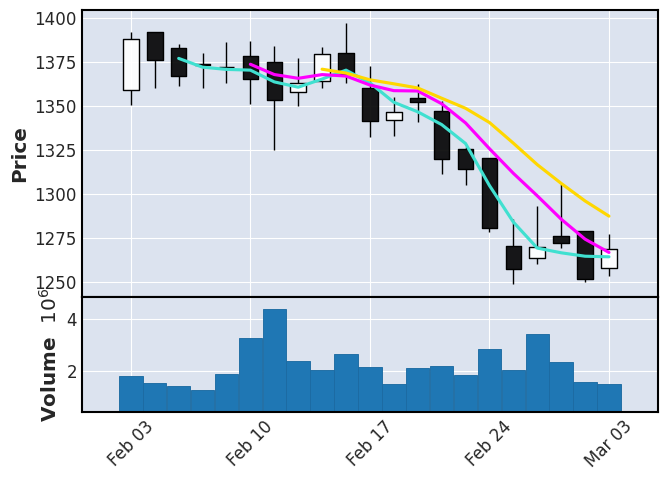

MARUTI.NS


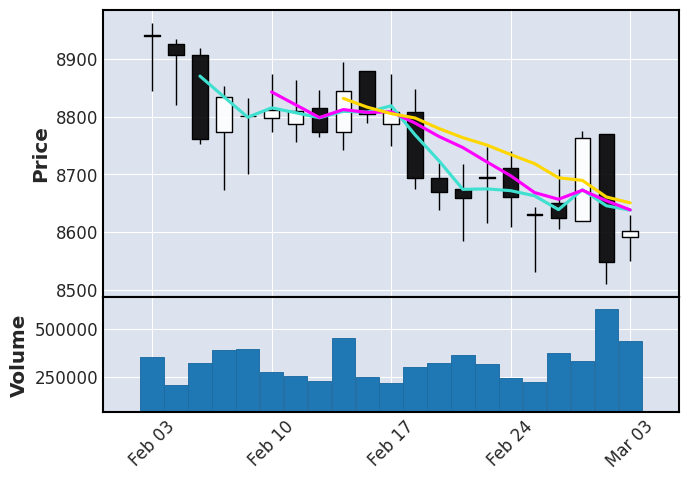

NESTLEIND.NS


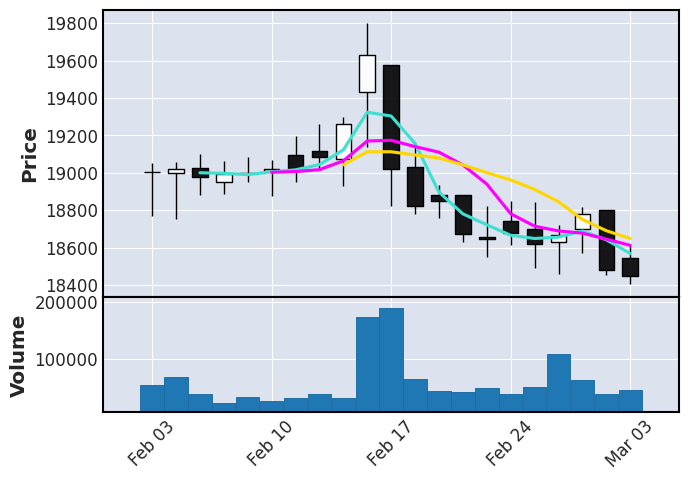

NTPC.NS


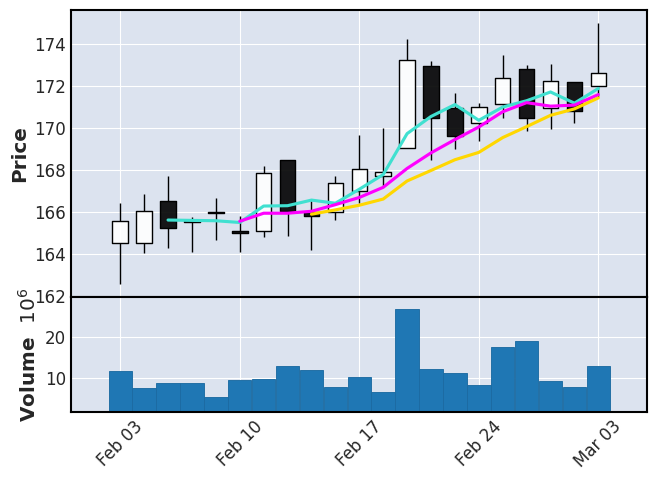

ONGC.NS


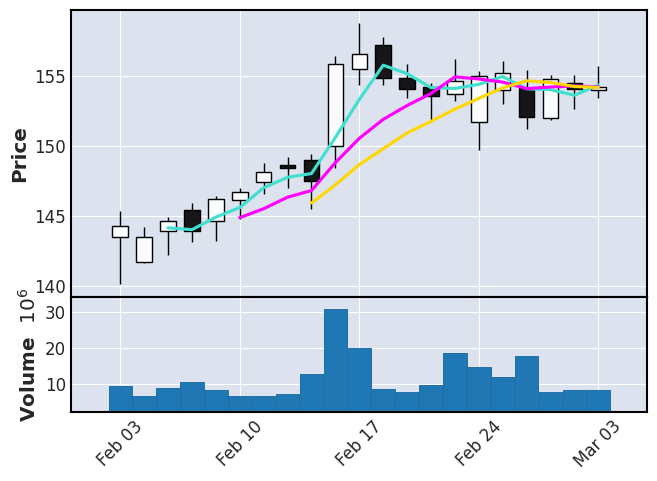

POWERGRID.NS


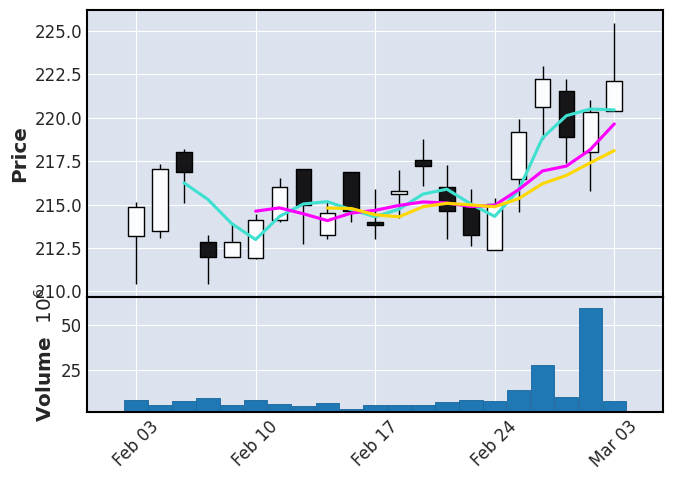

RELIANCE.NS


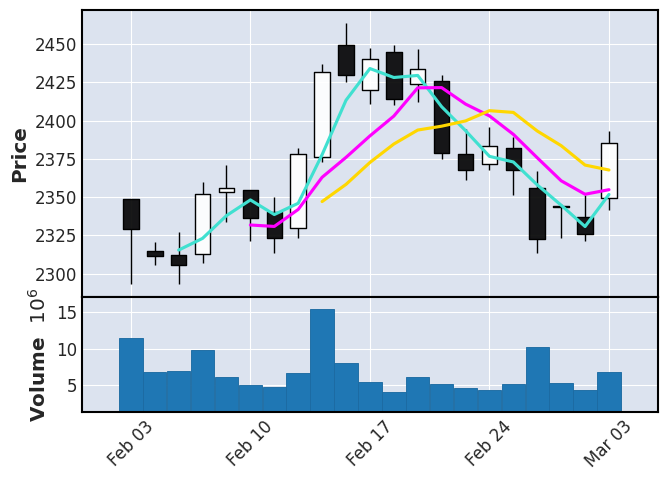

SBIN.NS


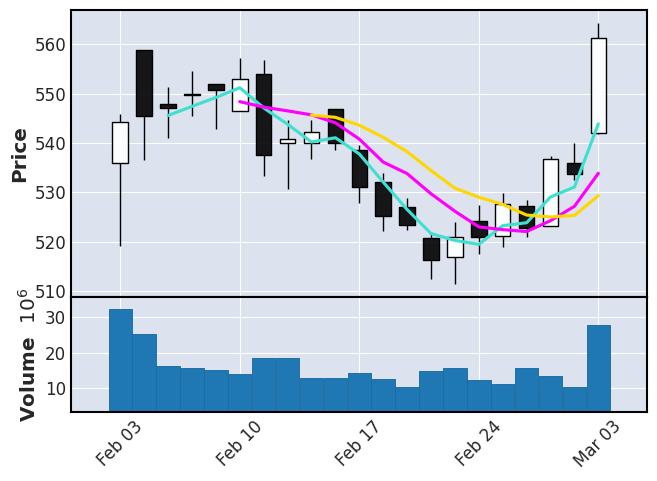

SBILIFE.NS


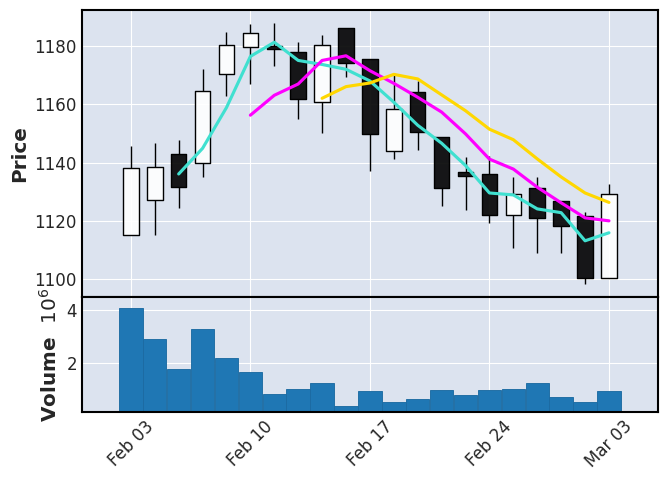

SUNPHARMA.NS


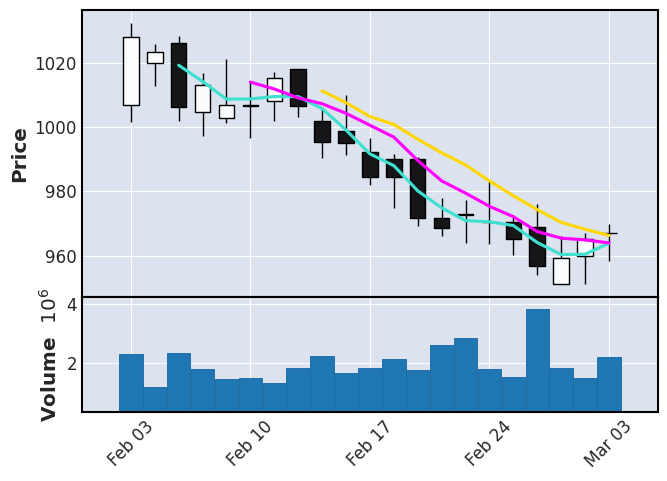

TATAMOTORS.NS


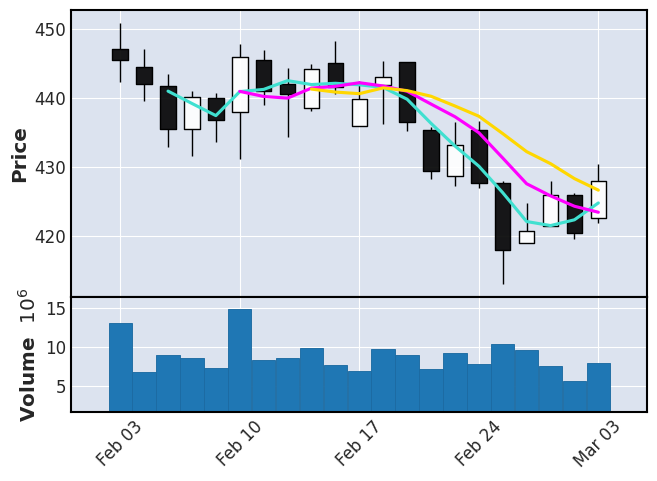

TATASTEEL.NS


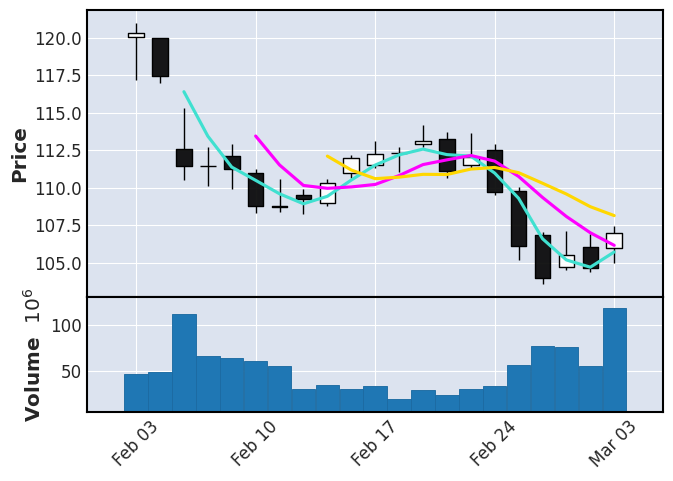

TCS.NS


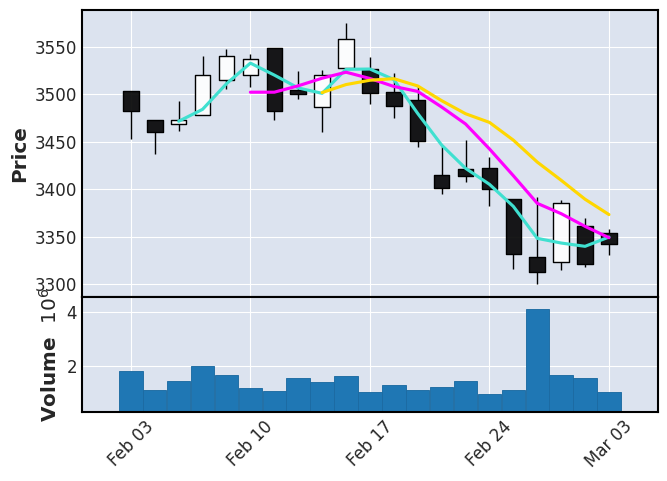

TATACONSUM.NS


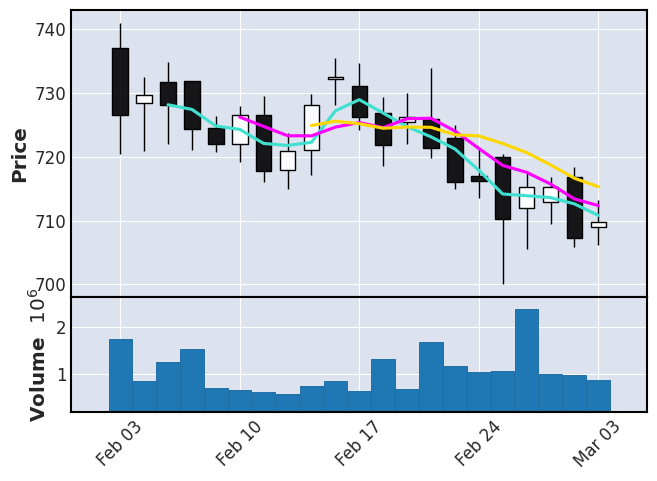

TECHM.NS


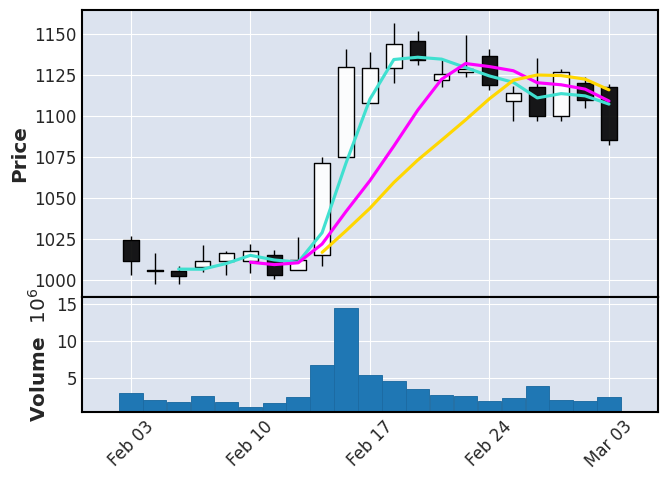

TITAN.NS


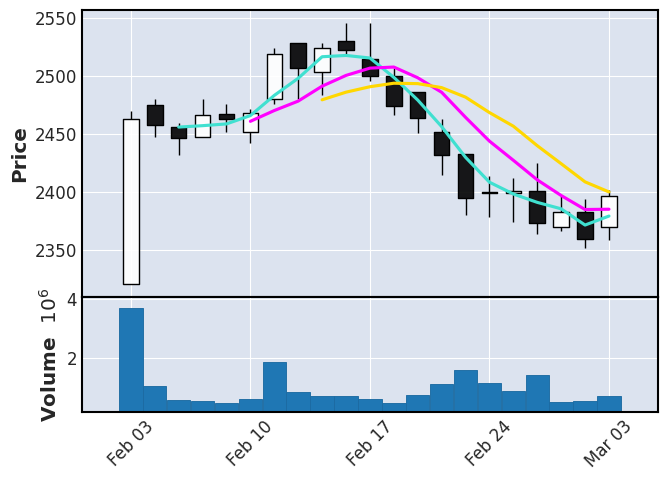

ULTRACEMCO.NS


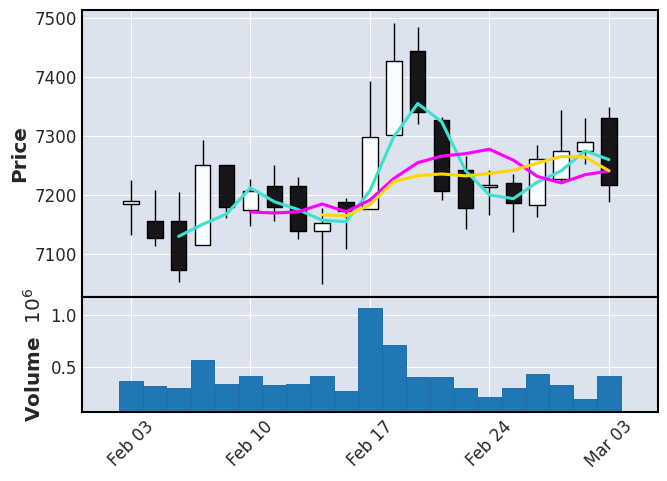

UPL.NS


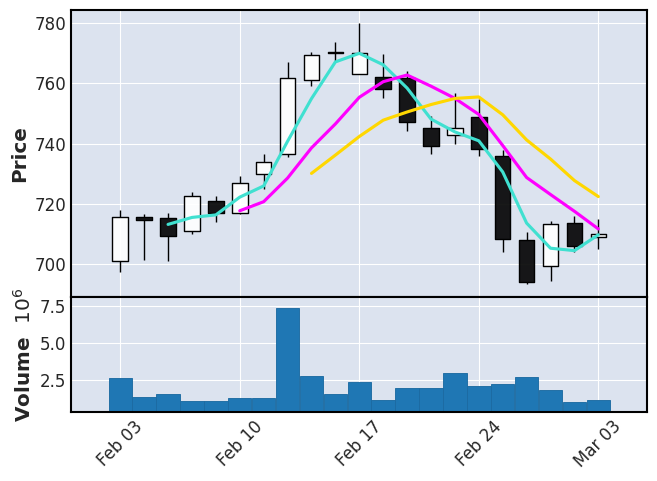

WIPRO.NS


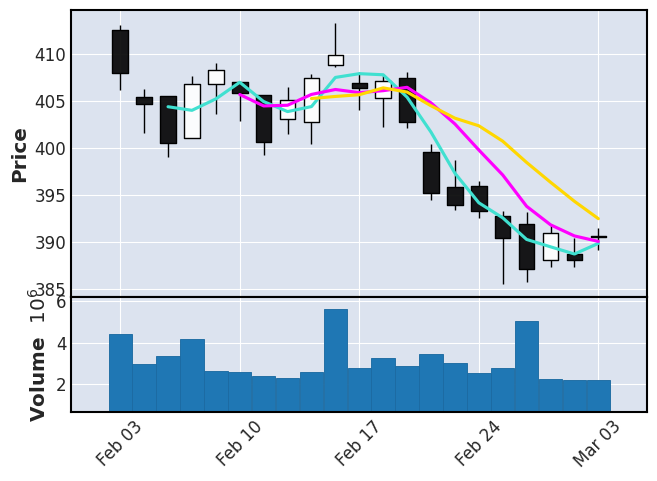

In [7]:
for symbol in stockPandasTot:
    stockPandas = stockPandasTot[symbol]
    print(symbol)
    mpf.plot(stockPandas.iloc[::-1],type='candle',mav=(3,6,9),volume=True)